# **Ejercicios de pair programming Módulo 3 Sprint 1**
## **Regreción Lineal: Lección 10 - Random Forest**
---

In [1]:
import os
# Tratamiento de datos
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd

# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado y evaluación
# ------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV

# Barra de progreso de un proceso
# ------------------------------------------------------------------------------
from tqdm import tqdm

# Configuración warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('once')

En el pair programming de hoy debéis usar el csv que guardastéis cuando hicistéis el pairprgramming de codificicación (este csv debería tener las variables estadandarizas).  
En pairprogramming anteriores ajustastéis vuestro datos a una regresión lineal y a un Decision Tree. El objetivo de hoy es:  
- Ajustar el modelo a un Random Forest  
- Extraer las métricas  
- Debatid entre vosotras que modelo es mejor y por qué (basándose en las métricas)  

In [2]:
df = pd.read_csv("datos/soci_econ_country_profiles_encoding.csv", index_col = 0)
df.head(2)

country        region  restaurant_price_index  population_2017  \
0  Argentina  SouthAmerica                   50.37         0.432582   
1  Australia       Oceania                   77.12         0.095085   

   employment_agriculture  employment_industry  employment_services  \
0               -0.331263             0.131944             0.315638   
1               -0.273292            -0.368056             0.487805   

   education  quality_of_life_index  purchasing_power_index  ...  \
0   0.258824              -0.022740               -0.243315  ...   
1   0.211765               0.550795                0.660990  ...   

   cost_of_living  consumer_price_index  human_capital_index  inflation  \
0        0.080347             -0.036551            -0.572700   0.374915   
1        0.893666              0.102195             0.566766  -0.030665   

   urban_population  population_age_distribution_0_14  \
0          0.605509                          0.927114   
1          0.393466                          0.239067   

   population_age_distribution_60_plus  international_migrant_stock  \
0                            -0.437736                    -0.307692   
1                            -0.015094                     1.538462   

   restaurant_price_index_normal  region_map  
0                       4.246653    4.043640  
1                       4.749998    4.752619  

[2 rows x 21 columns]

In [3]:
# separamos la variable respuesta y las predictoras que usaremos para el modelo
X = df.drop(["restaurant_price_index_normal", 'country', 'region', 'restaurant_price_index'], axis = 1)
y = df["restaurant_price_index_normal"]

In [4]:
# dividimos los datos en los conjuntos de entrenamiento (train) y de test.
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [5]:
param = {"max_depth": [2,4, 6], 
        "max_features": [1,2,3,4],
        "min_samples_split": [10, 15, 20],
        "min_samples_leaf": [10, 15, 20],
        "random_state": [99]} 

In [6]:
gs_rf = GridSearchCV(
            estimator=RandomForestRegressor(), # tipo de modelo que queremos hacer
            param_grid= param, # que hiperparámetros queremos que testee
            cv=10, # crossvalidation que aprendimos en la lección de regresión lineal intro. 
            verbose=-1, # para que no nos printee ningún mensaje en pantalla
            return_train_score = True, # para que nos devuelva el valor de las métricas de set de datos de entrenamiento
            scoring="neg_mean_squared_error") # la métrica que queremos que nos devuelva

In [7]:
# ajustamos el modelo que acabamos de definir en el GridSearch
gs_rf.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [2, 4, 6], 'max_features': [1, 2, 3, 4],
                         'min_samples_leaf': [10, 15, 20],
                         'min_samples_split': [10, 15, 20],
                         'random_state': [99]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=-1)

In [8]:
# al igual que el decision tree podemos sacar cual es nuestro mejor bosque
# En este caso,  nuestro mejor bosque es aquel que esta formado por arboles de 6 de profundidad, usa 4 variables y que tiene  un min_samples_leaf y un min_samples_split de 10. 
bosque = gs_rf.best_estimator_
bosque

RandomForestRegressor(max_depth=2, max_features=4, min_samples_leaf=10,
                      min_samples_split=10, random_state=99)

In [9]:
y_pred_test_rf = bosque.predict(x_test)
y_pred_train_rf = bosque.predict(x_train)

In [10]:
def metricas(y_test, y_train, y_test_pred, y_train_pred, tipo_modelo):
    
    
    resultados = {'MAE': [mean_absolute_error(y_test, y_test_pred), mean_absolute_error(y_train, y_train_pred)],
                'MSE': [mean_squared_error(y_test, y_test_pred), mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(mean_squared_error(y_test, y_test_pred)), np.sqrt(mean_squared_error(y_train, y_train_pred))],
                'R2':  [r2_score(y_test, y_test_pred), r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    df["modelo"] = tipo_modelo
    return df

In [11]:
# sacamos las métricas para ver si hay overfitting o unerfitting, para modificar la profundidad en función de estos resultados

rf_results = metricas(y_test, y_train, y_pred_test_rf, y_pred_train_rf, "Random Forest I")
rf_results

MAE       MSE      RMSE        R2    set           modelo
0  0.201870  0.066661  0.258188  0.789045   test  Random Forest I
1  0.225425  0.081228  0.285005  0.779882  train  Random Forest I

In [12]:
# igual que en la clase de decision tree, juntemos estos resultados con los obtenidos en los modelos que hemos hecho hasta ahora
# lo primero que tenemos que hacer es cargar el csv con todos los resultados que guardamos en el jupyter anterior

df_LR_DT_results = pd.read_csv("datos/resultados_boston_LR_DT.csv", index_col = 0)
df_LR_DT_results

MAE       MSE      RMSE        R2    set            modelo
0  0.237572  0.088985  0.298304  0.718399   test  Decission Tree I
1  0.000000  0.000000  0.000000  1.000000  train  Decission Tree I
0  0.188243  0.055945  0.236526  0.822958   test  Decision tree II
1  0.251930  0.101996  0.319369  0.723602  train  Decision tree II

In [13]:
# concatenamos el csv anterior con los resultados obtenidos en este modelo

df_todos_resultados = pd.concat([rf_results, df_LR_DT_results], axis = 0)
df_todos_resultados

MAE       MSE      RMSE        R2    set            modelo
0  0.201870  0.066661  0.258188  0.789045   test   Random Forest I
1  0.225425  0.081228  0.285005  0.779882  train   Random Forest I
0  0.237572  0.088985  0.298304  0.718399   test  Decission Tree I
1  0.000000  0.000000  0.000000  1.000000  train  Decission Tree I
0  0.188243  0.055945  0.236526  0.822958   test  Decision tree II
1  0.251930  0.101996  0.319369  0.723602  train  Decision tree II

In [14]:

# vamos a crearnos un dataframe, igual que hicimos en la clase anterior con la importancia de cada una de las variables incluidas en el modelo

importancia_predictores = pd.DataFrame(
                            {'predictor': x_train.columns,
                             'importancia': bosque.feature_importances_}
                            )


# ordenamos de mayor a menor los resultados
importancia_predictores.sort_values(by=["importancia"], ascending=False, inplace = True)

# printeamos los resultados
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores

Importancia de los predictores en el modelo
-------------------------------------------


predictor  importancia
8                        cost_of_living     0.252826
3                   employment_services     0.185771
16                           region_map     0.100482
15          international_migrant_stock     0.097393
1                employment_agriculture     0.092974
6                purchasing_power_index     0.069290
10                  human_capital_index     0.059538
12                     urban_population     0.056016
2                   employment_industry     0.039401
9                  consumer_price_index     0.019238
5                 quality_of_life_index     0.011492
14  population_age_distribution_60_plus     0.010131
0                       population_2017     0.002942
11                            inflation     0.002073
7                          safety_index     0.000435
4                             education     0.000000
13     population_age_distribution_0_14     0.000000

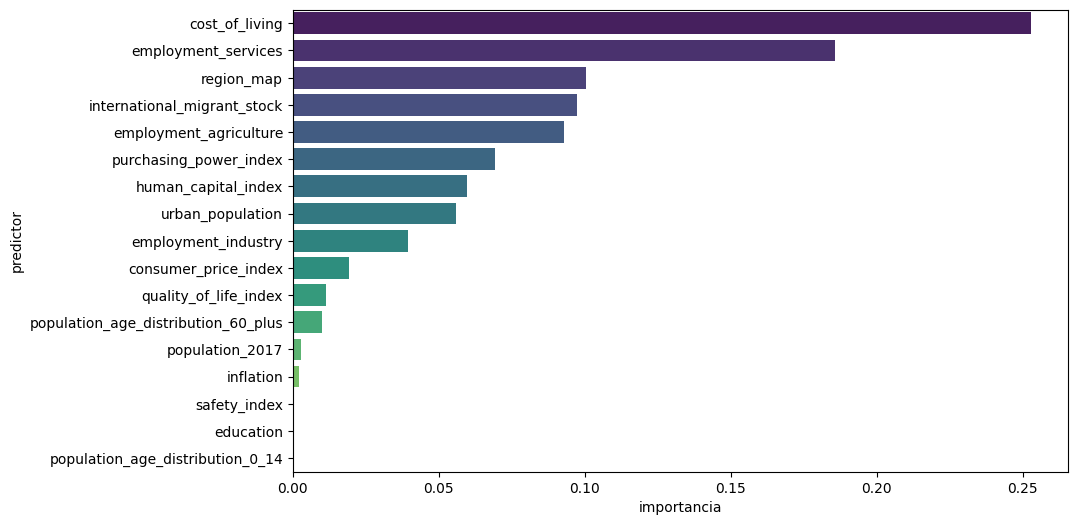

In [15]:
# por último ploteamos los resultados para verlo de una forma más amigable. 

plt.figure(figsize=(10,6))
sns.barplot(x = "importancia", y = "predictor", data = importancia_predictores, palette="viridis");
plt.show()

In [16]:
# probamos otro modelo
param2 = {"max_depth": [2,4, 6], 
        "max_features": [1,2,3,4],
        "min_samples_split": [10, 15, 20],
        "min_samples_leaf": [10, 15, 20],
        "random_state": [98]} 

In [17]:
gs_rf2 = GridSearchCV(
            estimator=RandomForestRegressor(),
            param_grid= param2,
            cv=10, 
            verbose=-1, 
            return_train_score = True, 
            scoring="neg_mean_squared_error")

In [18]:
# ajustamos el modelo que acabamos de definir en el GridSearch
gs_rf2.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [2, 4, 6], 'max_features': [1, 2, 3, 4],
                         'min_samples_leaf': [10, 15, 20],
                         'min_samples_split': [10, 15, 20],
                         'random_state': [98]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=-1)

In [19]:
# al igual que el decision tree podemos sacar cual es nuestro mejor bosque
# En este caso,  nuestro mejor bosque es aquel que esta formado por arboles de 6 de profundidad, usa 4 variables y que tiene  un min_samples_leaf y un min_samples_split de 10. 
bosque2 = gs_rf2.best_estimator_
bosque2

RandomForestRegressor(max_depth=2, max_features=4, min_samples_leaf=10,
                      min_samples_split=10, random_state=98)

In [20]:
y_pred_test_rf2 = bosque2.predict(x_test)
y_pred_train_rf2 = bosque2.predict(x_train)

In [21]:
rf_results2 = metricas(y_test, y_train, y_pred_test_rf2, y_pred_train_rf2, "Random Forest II")
rf_results2

MAE       MSE      RMSE        R2    set            modelo
0  0.206193  0.069549  0.263722  0.779905   test  Random Forest II
1  0.235140  0.084927  0.291422  0.769858  train  Random Forest II

In [22]:
# concatenamos el csv anterior con los resultados obtenidos en este modelo

df_todos_resultados = pd.concat([rf_results2, df_todos_resultados], axis = 0)
df_todos_resultados

MAE       MSE      RMSE        R2    set            modelo
0  0.206193  0.069549  0.263722  0.779905   test  Random Forest II
1  0.235140  0.084927  0.291422  0.769858  train  Random Forest II
0  0.201870  0.066661  0.258188  0.789045   test   Random Forest I
1  0.225425  0.081228  0.285005  0.779882  train   Random Forest I
0  0.237572  0.088985  0.298304  0.718399   test  Decission Tree I
1  0.000000  0.000000  0.000000  1.000000  train  Decission Tree I
0  0.188243  0.055945  0.236526  0.822958   test  Decision tree II
1  0.251930  0.101996  0.319369  0.723602  train  Decision tree II

CONCLUSIÓN:
- Los datos sugieren que el modelo más adecuado es Random Forest I por las siguientes razones:
    - El R2 del Decision tree II para el test es mayor pero la diferencia respecto al R2 del train es considerablemente superior a la de los modelos Random Forest I y II. Además, los valores de los residuos del train de Decision Tree II son mayores que los otros modelos.
    - Las métricas de los dos modelos de Random Forest son bastante buenas (residuos bajos y R2 superiores a 0.7) y muy parecidas. Ambos podrían ser adecuados y más estables que el de Decision Tree II, ya que tienen muy poca diferencia entre las métricas de train y de test.
    - Las métricas del modelo Random Forest I son ligeramente mejores (R2 mayor y residuos menores) que las de Random Forest II, por lo que los datos sugieren que sería el mejor modelo de los realizados. 

In [23]:

# vamos a crearnos un dataframe, igual que hicimos en la clase anterior con la importancia de cada una de las variables incluidas en el modelo

importancia_predictores2 = pd.DataFrame(
                            {'predictor': x_train.columns,
                             'importancia': bosque2.feature_importances_}
                            )


# ordenamos de mayor a menor los resultados
importancia_predictores2.sort_values(by=["importancia"], ascending=False, inplace = True)

# printeamos los resultados
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores2

Importancia de los predictores en el modelo
-------------------------------------------


predictor  importancia
3                   employment_services     0.221123
1                employment_agriculture     0.164358
8                        cost_of_living     0.151302
15          international_migrant_stock     0.143708
16                           region_map     0.103532
5                 quality_of_life_index     0.056152
6                purchasing_power_index     0.049073
10                  human_capital_index     0.034568
11                            inflation     0.018682
4                             education     0.016046
9                  consumer_price_index     0.012766
14  population_age_distribution_60_plus     0.011933
12                     urban_population     0.007234
13     population_age_distribution_0_14     0.005147
2                   employment_industry     0.001962
7                          safety_index     0.001573
0                       population_2017     0.000842

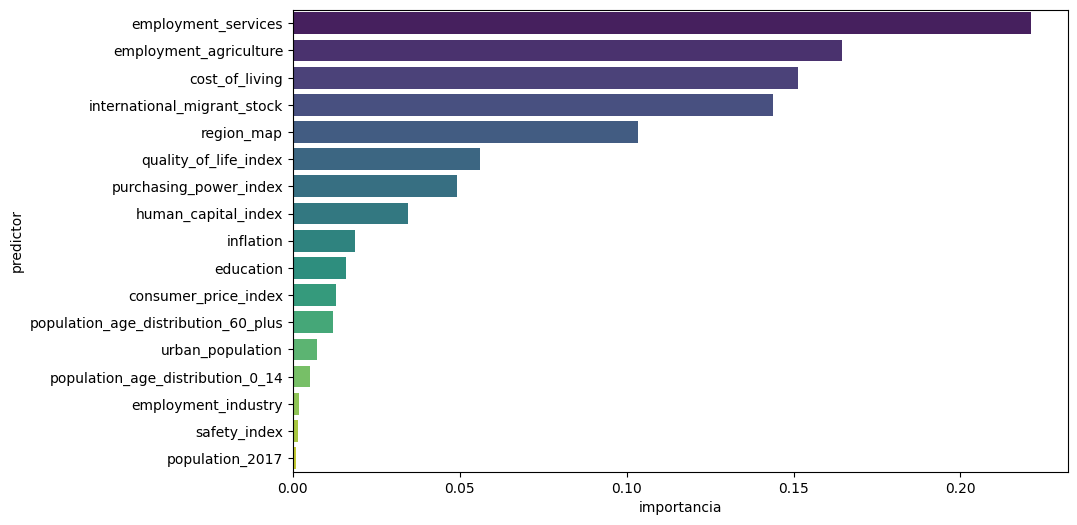

In [24]:
# por último ploteamos los resultados para verlo de una forma más amigable. 

plt.figure(figsize=(10,6))
sns.barplot(x = "importancia", y = "predictor", data = importancia_predictores2, palette="viridis");
plt.show()

Si analizamos la importancia de las variables en ambos modelos de tipo Random Forest cabe destacar que, a pesar de tener métricas muy diferentes, hay mucha variación entre la importancia de las variables en uno y otro modelo, tanto entre las más importantes (cost of living por ejemplo) como entre las menos importantes (education por ejemplo)